# Comparison of Coral Bleaching estimates
This project will compare observational data from <a href="#refs">Hughes et al. (2018)</a> with results from a numerical model <a href="#refs">(Logan et al., 2018)</a>.  Each dataset is global, but the scales and coverage vary widely.  As a shorthand, I will refer to the 100 locations in the former as "Hughes reef areas" and the 1,925 locations in the latter as "Logan reef cells".

The goal is to evaluate the utility of using the Hughes data to validate or calibrate the Logan model.  The Logan model, based on <a href="#refs">(Logan et al., 2014)</a>, is not intended to model the details of individual reefs, but rather to show trends which are useful in evaluating the effect of different climate scenarios or in comparing the likely effect of human interventions to protect corals.  Thus a reef-by-reef comparison is not expected to be exact, but I want see how much correlation there is, both reef-by-reef and regionally, between the two datasets.

The following notebook has several sections.
1. Data input and display of raw data
    + <a href="#HughesData">Hughes</a>
    + <a href="#LoganData">Logan</a>
2. <a href="#mapcompare">Map-based comparison of the datasets</a>
3. <a href="#matching">Matching of Hughes reef areas to Logan reef cells</a>
4. <a href="#reefbyreef">Scatterplot comparisons of Hughes and Logan reef-by-reef data</a>
5. <a href="#pca">Principal component analysis to look for variables by which to group reefs</a>
6. <a href="#variable_scatter">Scatterplot comparisons of pertinent variables</a>
7. <a href="#cumulative">Comparison of world and regional bleaching totals over time</a>
8. <a href="#refs">References</a>

In [43]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import cartopy.crs as ccrs

from coral_project_functions import make_coral_map

# Read data from the Hughes supplemental material.  The first
# sheet is a cut-and-paste from their document with obvious typos
# fixed by hand and a few columns added for easier data manipulation.
# The second sheet has been arranged for easier import.
filename = '../data/Hughes100Reefs.xlsx' 
hughes = pd.read_excel(filename,header=0,sheet_name=1, na_values='-')
# Missing size values are set to zero - be careful how they are used later!
# hughes.Size_km2 = hughes.Size_km2.replace({"-": "0"})

<a id="HughesData"></a>
## Columns from Hughes et al. are
1. Hughes Reef - the index used in their data, 1-100.
2. Region - my code for their region labels.
    + AuA - Australasia
    + IO-ME - Indian Ocean/ Middle East
    + Pac - Pacific
    + WAtl - West Atlantic
3. Location - their location name for each reef. 
4. Numeric Lat - decimal values between about -35 and +35
5. Numeric Lon - decimal values between -180 and +180
6. Size_km2 - area in square kilometers, sometimes omitted.
7. Year - columns 7 to 43 - one column for each year of data, 1980 to 2016.  Values are blank, S, or M.
44. Severe count - the count of the number of cells in this row with the entry "S". values 0-7
45. Moderate count - the count of the number of cells in this row with the entry "M".  Values 0-12

In [44]:
# Now read our data for reef cell locations.
import scipy.io as sio

# Reference for all data for the 1,925 reef cell model.
# This has not been submitted to a journal yet, so all is subject to change:
#
# Logan, C. A., Dunne, J. P., Ryan, J. S., Baskett, M. L. & Donner, S. D. Can symbiont
# diversity and evolution allow corals to keep pace with global warming
# and ocean acidification? prep (2018).

# A copy of the data is in this repository.  The reference copy is in
# my Coral-Model-Data repository in the ProjectionsPaper directory.
mat_data = sio.loadmat('../data/ESM2M_SSTR_JD.mat')
# Put just the lat/lon columns into a data frame.  Note that they are stored
# with longitude first in the incoming data.
cells = pd.DataFrame(mat_data['ESM2M_reefs_JD'], columns=['Lon', 'Lat'])

# The same mat file has SST data, not used in this notebook until the PCA section.
sst = mat_data['SSTR_2M26_JD']
cells['SST'] = np.mean(sst, axis=1)
cells['variance'] = np.var(sst, axis=1)

del sst  # big, and no longer needed (though the value of del is debated online)

# Next, read the bleaching counts from a MATLAB mat file written for this purpose.
mat_data = sio.loadmat('../data/HughesCompEvents_selV_rcp60E=1OA=1.mat')
# Put the bleaching counts into a data frame.  These counts are the total for each
# reef during 1980 to 2016.
modelBleaching = pd.DataFrame(mat_data['events80_2016'])
modelBleaching.rename(columns={0: 'Events'}, inplace=True)
# Be we really want this in the cells dataframe
cells['Events'] = modelBleaching['Events']

# For later use, also load the un-summarized data which has the bleaching
# flags for each reef and year from 1980 to 2016.  Branching and massive coral
# are treated separately.
massive_bleach = np.array(mat_data['events80_2016_detail'][:, :, 0])
branching_bleach = np.array(mat_data['events80_2016_detail'][:, :, 1])

del mat_data
del modelBleaching
cells.head()

,Lon,Lat,SST,variance,Events
0,-179.5,-19.145246,26.051836,2.952026,2
1,-179.5,-18.311912,26.373503,2.654303,2
2,-179.5,-17.500333,26.622993,2.420091,2
3,-179.5,-16.710136,26.928833,2.224938,1
4,-179.5,-15.940584,27.229943,1.902959,1


<a id="LoganData"></a>
## Columns from the Logan et al. data are
For each cell:
1. Lat - the latitude of the centroid
2. Lon - the longitude of the centroid
3. Events - the number of bleaching events between 1980 and 2016, inclusive

<IPython.core.display.Javascript object>


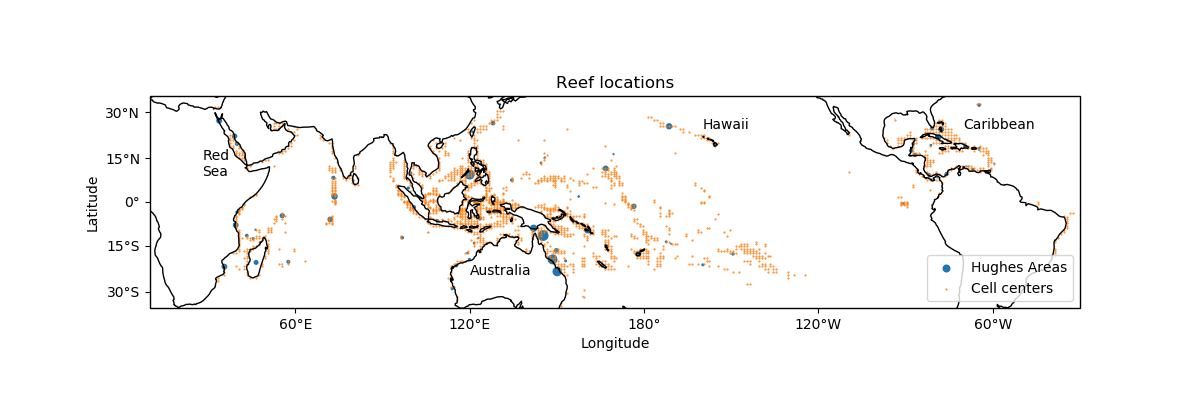

Area size min/max/mean/median: 2.0 9319.0 945.1030927835052 343.0 km^2


Text(20,25,'Hawaii')

In [45]:
plt.figure(figsize=[12, 4])
ax = make_coral_map()
# Hughes reef areas can be large.  Make size proportional.  Conveniently, the marker
# size argument is in square units.  However, our map is in degree units and the areas
# are in kilometers.  This is a rough conversion relating pixels to square degrees.
conversion = 60*(1/111)**2
area_sizes = hughes.Size_km2.astype(float)
# Do some stats with no NaN values
sss = area_sizes[~np.isnan(area_sizes)]
print("Area size min/max/mean/median:", min(sss), max(sss), np.mean(sss), np.median(sss), 'km^2')

lon = hughes['Numeric Lon']
plt.scatter(lon-180*(np.sign(lon)-1), hughes['Numeric Lat'], marker='o',
            s=conversion*area_sizes,
            label='Hughes Areas', transform=ccrs.PlateCarree())
# Mark our cells with small dots.
lon = cells['Lon']
plt.scatter(lon-180*(np.sign(lon)-1), cells['Lat'], marker='.', s=1, label='Cell centers',
           transform=ccrs.PlateCarree())
plt.title('Reef locations')
plt.legend()
plt.text(110, 25, 'Caribbean')
plt.text(-60, -25, 'Australia')
plt.text(-152, 9, 'Red\nSea')
plt.text(20, 25, 'Hawaii')

<IPython.core.display.Javascript object>


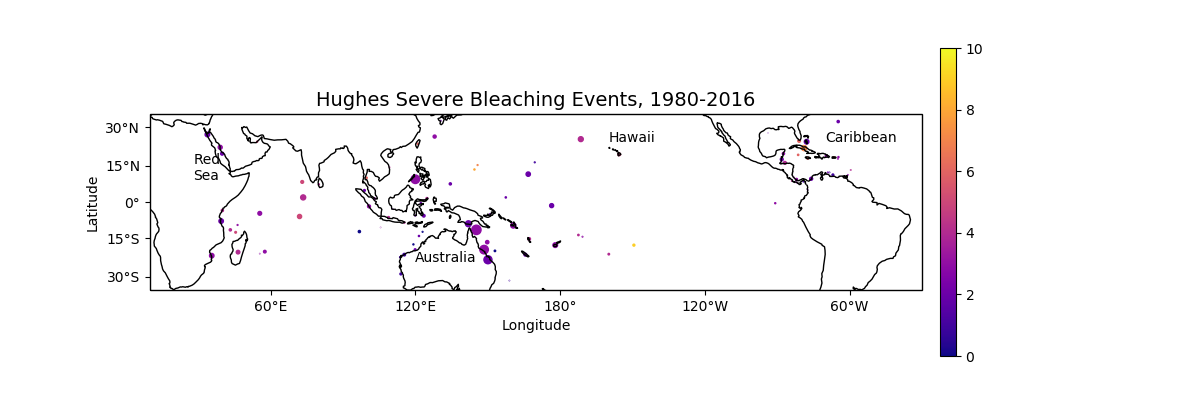

In [46]:
# Now try an indication of bleaching severity.
plt.figure(figsize=[12, 4])
ax = make_coral_map()
lon = hughes['Numeric Lon']
severity = hughes['Severe count']
plt.scatter(lon-180*(np.sign(lon)-1), hughes['Numeric Lat'], marker='o', 
            s=conversion*area_sizes,
            label='Hughes Areas',
            c=severity,
            cmap="plasma",
            transform=ccrs.PlateCarree())

plt.title('Hughes Severe Bleaching Events, 1980-2016', fontsize=14)
plt.clim(0, 10)
plt.colorbar(pad=0.02)
plt.text(110, 25, 'Caribbean')
plt.text(-60, -25, 'Australia')
plt.text(-152, 9, 'Red\nSea')
plt.text(20, 25, 'Hawaii');

<IPython.core.display.Javascript object>


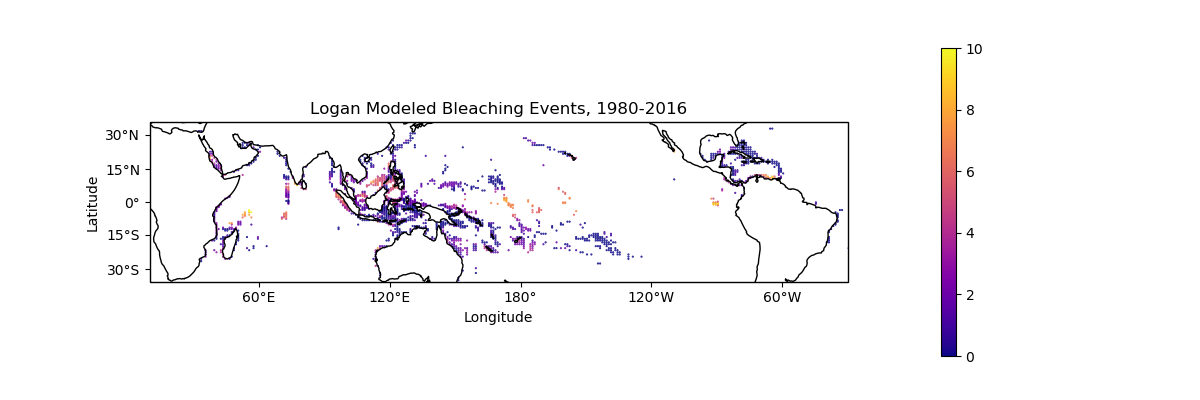

In [47]:
# Look at Bleaching events from the numerical model, using the same scale as
# the previous plot of Hughes data.
plt.figure(figsize=[12, 4])
ax = make_coral_map()

lon = cells['Lon']
plt.scatter(lon-180*(np.sign(lon)-1), cells['Lat'], c = cells['Events'],
            marker='.', s=1, label='Events', cmap="plasma",
            transform=ccrs.PlateCarree())
plt.title('Logan Modeled Bleaching Events, 1980-2016')
plt.clim(0, 10)
plt.colorbar(pad=0.10);

In [48]:
hughes.head()

,Hughes Reef,Region,Location,Numeric Lat,Numeric Lon,Size_km2,1980,1981,1982,1983,...,2009,2010,2011,2012,2013,2014,2015,2016,Severe count,Moderate count
0,1,AuA,"Australia, Coral Sea Northern",-16.5,149.8,1165.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,3,1
1,2,AuA,"Australia, Coral Sea Southern",-20.0,153.0,231.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,0,1
2,3,AuA,"Australia, GBR Central",-19.5,148.5,7735.0,M,NaN,NaN,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,3,5
3,4,AuA,"Australia, GBR Northern",-11.5,145.3,9319.0,M,NaN,NaN,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,3,2
4,5,AuA,"Australia, GBR Southern",-23.5,150.1,6872.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,2,2


<a id="matching"></a>
## Matching Hughes areas to Logan reef cells
To make a fair comparison, we need to figure out which of our cells match Hughes reef areas.  Each area has a center and an area, so we can use a circle of that area as a first-order guess.  Unfortunately, it seems that the areas are actually far from circular, because some of the centers are far inland.

The code below uses a scipy tool to find spatial matches between the two sets of data.  The matches found here can be considered close matches, because the cells must overlap, or nearly so.

In [49]:
# Use scipy.spatial.cKDTree to find neighbors.
from scipy import spatial
# Build the tree (a binary trie) of our cells.
# NOTE: cells.as_matrix({'Lon', 'Lat'}) does not return the columns in a determinate order!
# explicitly stack the columns instead.
lonlat = np.column_stack((cells['Lon'], cells['Lat']))
tree = spatial.cKDTree(lonlat)

# For each of the 100 Hughes cells, get a list of our cells which are likely to overlap.
# These will be used
hughes = hughes.assign(radius_km=hughes.Size_km2**0.5)
cell_lists = [[] for i in range(len(hughes))]
match_idx = np.zeros(len(hughes), dtype=np.bool)
for i in range(len(hughes)):
    # convert radius to degrees (ignoring change of size with latitude for now)
    # also, add 0.5 degrees as a rough allowance for our cell size
    # radius = 0.5 + hughes.radius_km[i] / 111
    radius = 0.5 + hughes.radius_km[i] / 111
    c = tree.query_ball_point([hughes['Numeric Lon'][i], hughes['Numeric Lat'][i]],
                              radius, n_jobs=2)
    # Convert zero-based indexes to 1-based cell numbers.
    cell_lists[i] = [x+1 for x in c]
    match_idx[i] = len(c) > 0

print(cell_lists)

[[1601, 1602, 1624], [], [1597, 1578, 1560, 1579, 1598], [1513, 1512, 1528], [], [991], [1738], [], [961], [], [], [1679], [], [1496], [], [994, 993], [1198, 1197], [915], [935], [1267, 1268], [1093, 1126], [1232, 1233], [813, 812, 814], [], [1357, 1342], [831], [1630, 1631, 1652], [1107, 1108, 1136, 1135, 1137], [1759, 1758, 1766], [], [807, 808], [], [1181, 1225], [851], [762, 763], [1086], [1147, 1148], [656, 665, 657, 666], [553], [], [680, 706], [516, 517], [], [], [695, 696, 697], [636, 635], [565, 566], [476, 477], [502], [487, 488], [624, 625], [572], [], [], [492, 493, 494], [], [71], [], [1540], [103], [275], [], [1906, 1912, 1913], [144], [240, 241, 239], [1525, 1524], [126], [70, 73], [], [1903, 1904], [], [1785, 1786], [1457, 1458], [], [], [1811, 1810, 1827, 1828], [57], [1798, 1818], [342, 331, 343], [445], [258], [422], [402], [420], [301], [348], [], [329], [398, 402], [399], [311, 304], [224], [256, 265, 266], [338, 339], [260, 261], [283, 296], [], [419], [441, 440],

<a id="mapcompare"></a>
## Comparison of beaching in each area
Now that areas and cells are associated, we can store nearby Logan bleaching values in the Hughes dataframe and use that to plot a comparison.

<IPython.core.display.Javascript object>


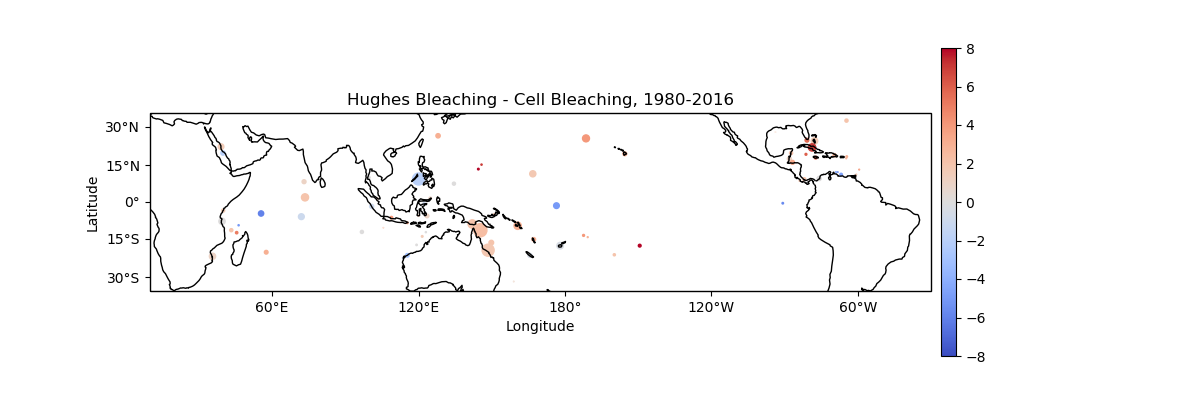

There are 76 areas with comparisons.


In [52]:
# Now that we have a correspondence between Hughes areas and Logan cells, we can
# compare the bleaching for those which have some overlap.
# Add a column for cell-based bleaching values
hughes = hughes.assign(cell_bleach=np.zeros(len(hughes)))
for i in range(len(hughes)):
    if len(cell_lists[i]) > 0:
        count = 0;
        for n in cell_lists[i]:
            # "n-1" because cells are 1-based and modelBleaching is 0-based
            count = count + cells.loc[n-1, 'Events']
        hughes.loc[i, 'cell_bleach'] = count / len(cell_lists[i])
        
# Plot the Hughes reefs, but only those which have Logan cells to compare to.
# Color the markers by the difference between the two bleaching values.
plt.figure(figsize=[12, 4])
ax = make_coral_map()

conversion = 120*(1/111)**2
lon = hughes[match_idx]['Numeric Lon']

print("There are", len(lon), "areas with comparisons.")
severity = hughes[match_idx]['Severe count'] - hughes[match_idx]['cell_bleach']

plt.scatter(lon, hughes[match_idx]['Numeric Lat'], marker='o', 
            s=conversion*hughes[match_idx].Size_km2.astype(float),
            label='Hughes Areas',
            c=severity,
            cmap='coolwarm',
            transform=ccrs.PlateCarree())

plt.title('Hughes Bleaching - Cell Bleaching, 1980-2016')
plt.clim(-8, 8)
plt.colorbar(pad=0.01)

## Assigning every cell a Hughes region
While not every area closely matches a cell and vice versa, it is reasonable to assign all Logan cells to some Hughes area of the world.  This is done by matching each cell to a nearby area, where the definition of "nearby" is relaxed until all cells have been matched.

There are two things to note here.  First, while most reef cells fall near an area treated by Hughes, Hughes has no areas on the Atlantic coast of Brazil.  Those are assigned to the "West Atlantic" region, but they are likely to be ecologically quite different than the Hughes "West Atlantic" areas, which are in the Caribbean and Gulf of Mexico, or north toward the Bahamas and Bermuda.  Second, some reef are reassigned manually because their proximity to the isthmus of Panama led to poor results with the automatic method.

Also, Hughes has no areas in the Solomon Islands or the Bismarck Sea N.E. of New Guinea.  It is not clear whether they are a better match to the Pacific or Australasian regions.  I have left these as matched automatically, except for a small group which are clearly Micronesian, in the Pacific region and one cell which may be Nauru.

In [53]:
# Add a new column
cells = cells.assign(Region='none')
cells_assigned = 0
r = 0.5
while cells_assigned < 1925:
    for i in range(len(hughes)):
        # 0 gives 15 comparisons, 0.5 gives 76, 2.0 gives 93.  In all cases there's an
        # insignificant negative correlation in bleaching.
        radius = r + hughes.radius_km[i] / 111
        c = tree.query_ball_point([hughes['Numeric Lon'][i], hughes['Numeric Lat'][i]],
                                  radius, n_jobs=-1)
        region = hughes.Region[i]
        #print('Reef', i, 'region', region, 'found ', c)
        for x in c:
            if cells.loc[x, 'Region'] == 'none':
                cells.loc[x, 'Region'] = region
                cells_assigned = cells_assigned + 1
    print('After r =', r, ',', cells_assigned, 'are assigned.')
    r = r * 2

# Some special cases are mis-identified with the approach above.
# South atlantic, off Brazil is initially id'd as Indian Ocean/ Middle East!
# Make a bounding box to specify these cells
box = [-40, -25, -26, -16]  # Lon, Lon, Lat, Lat 
cells.loc[(cells.Lat > box[2]) & (cells.Lat < box[3]) & (cells.Lon > box[0]) &
          (cells.Lon < box[1]), 'Region'] = "WAtl"
# Others off Brazil are labeled Pacific.
box = [-39, -34, -16, -8]
cells.loc[(cells.Lat > box[2]) & (cells.Lat < box[3]) & (cells.Lon > box[0]) &
          (cells.Lon < box[1]), 'Region'] = "WAtl"
# Some SW Caribbean cells are id'd as Pacific
#11.6, -83.7
#box = [-83, -80,  12, 16]
box = [-83.8, -80,  11.5, 16]
cells.loc[(cells.Lat > box[2]) & (cells.Lat < box[3]) & (cells.Lon > box[0]) &
          (cells.Lon < box[1]), 'Region'] = "WAtl"
box = [-81, -76, 8.8, 11]
cells.loc[(cells.Lat > box[2]) & (cells.Lat < box[3]) & (cells.Lon > box[0]) &
          (cells.Lon < box[1]), 'Region'] = "WAtl"
# A few micronesian cells are closer to a Hughes area sound of New Guinea than to micronesian
# areas, but they clearly belong with micronesia
box = [147, 153, 4, 11]
cells.loc[(cells.Lat > box[2]) & (cells.Lat < box[3]) & (cells.Lon > box[0]) &
          (cells.Lon < box[1]), 'Region'] = "Pac"
# Nauru?
box = [164, 169, -1, 3]
cells.loc[(cells.Lat > box[2]) & (cells.Lat < box[3]) & (cells.Lon > box[0]) &
          (cells.Lon < box[1]), 'Region'] = "Pac"

print('Pacific:', sum(cells['Region'] == 'Pac'))
print('Indian Ocean - Middle East:', sum(cells['Region'] == 'IO-ME'))
print('Australasia:', sum(cells['Region'] == 'AuA'))
print('West Atlantic:', sum(cells['Region'] == 'WAtl'))
print()

# Save the cells with region labels for use in another notebook.  This is
# only used in Reef_Scatterplots.
cells.to_pickle('../results/Logan_cells_events_region.pkl')
cells.head() 

After r = 0.5 , 142 are assigned.
After r = 1.0 , 305 are assigned.
After r = 2.0 , 623 are assigned.
After r = 4.0 , 1192 are assigned.
After r = 8.0 , 1753 are assigned.
After r = 16.0 , 1886 are assigned.
After r = 32.0 , 1910 are assigned.
After r = 64.0 , 1925 are assigned.
Pacific: 466
Indian Ocean - Middle East: 301
Australasia: 937
West Atlantic: 221



,Lon,Lat,SST,variance,Events,Region
0,-179.5,-19.145246,26.051836,2.952026,2,Pac
1,-179.5,-18.311912,26.373503,2.654303,2,Pac
2,-179.5,-17.500333,26.622993,2.420091,2,Pac
3,-179.5,-16.710136,26.928833,2.224938,1,Pac
4,-179.5,-15.940584,27.229943,1.902959,1,Pac


<IPython.core.display.Javascript object>


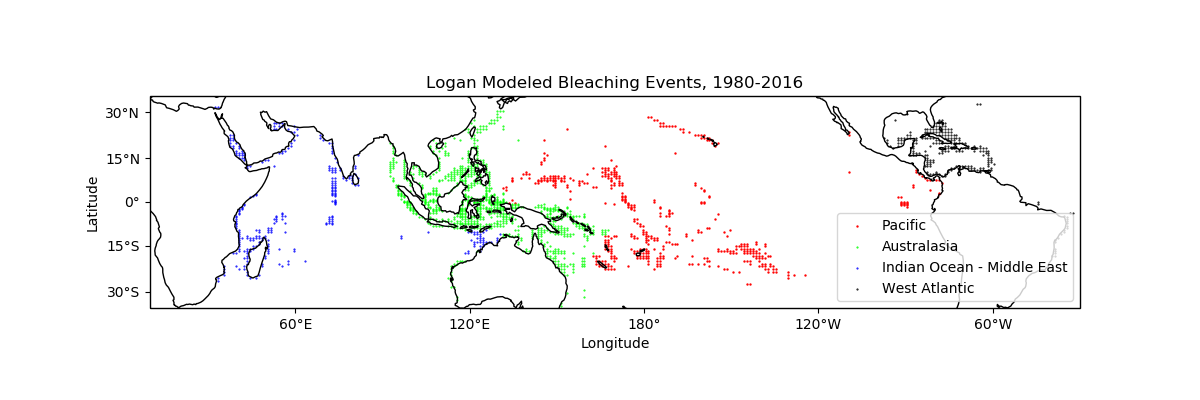

In [54]:
# Plot the Logan cells colored by region to check the assignments.
# First give each region number for easy use of a color map.
cells = cells.assign(RegionFlag='0')
cells.loc[cells.Region=='Pac', 'RegionFlag'] = 1;
cells.loc[cells.Region=='AuA', 'RegionFlag'] = 2;
cells.loc[cells.Region=='IO-ME', 'RegionFlag'] = 3;
cells.loc[cells.Region=='WAtl', 'RegionFlag'] = 4;

plt.figure(figsize=[12, 4])
ax = make_coral_map()
lon = cells[cells.RegionFlag==1]['Lon']
plt.scatter(lon-180*(np.sign(lon)-1), cells[cells.RegionFlag==1]['Lat'], c = [1.0, 0, 0],
            marker='.', s=2, label='Pacific', cmap="Dark2",
            transform=ccrs.PlateCarree())
lon = cells[cells.RegionFlag==2]['Lon']
plt.scatter(lon-180*(np.sign(lon)-1), cells[cells.RegionFlag==2]['Lat'], c = [0, 1.0, 0],
            marker='.', s=1, label='Australasia', cmap="Dark2",
            transform=ccrs.PlateCarree())
lon = cells[cells.RegionFlag==3]['Lon']
plt.scatter(lon-180*(np.sign(lon)-1), cells[cells.RegionFlag==3]['Lat'], c = [0, 0, 1.0],
            marker='.', s=1, label='Indian Ocean - Middle East', cmap="Dark2",
            transform=ccrs.PlateCarree())
lon = cells[cells.RegionFlag==4]['Lon']
plt.scatter(lon-180*(np.sign(lon)-1), cells[cells.RegionFlag==4]['Lat'], c = [0, 0, 0],
            marker='.', s=1, label='West Atlantic', cmap="Dark2",
            transform=ccrs.PlateCarree())
plt.title('Logan Modeled Bleaching Events, 1980-2016')
plt.legend(loc=0)

<a id="reefbyreef"></a>
## Reef-by-reef bleaching correlation
The initial comparison between Hughes areas and Logan reefs doesn't look great.  Try a scatterplot for all of the hughes area to see if there's at least some trend.  This is first done for the world, and then for each region separately.

<IPython.core.display.Javascript object>


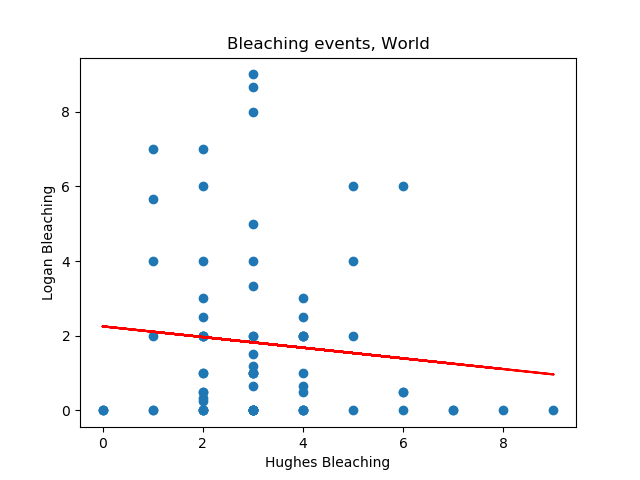

World r-squared: 0.011464523508040886


In [55]:
from coral_project_functions import bleach_scatter

h_match = hughes[match_idx]   
plt.figure()
bleach_scatter(hughes[match_idx], 'World')

<IPython.core.display.Javascript object>


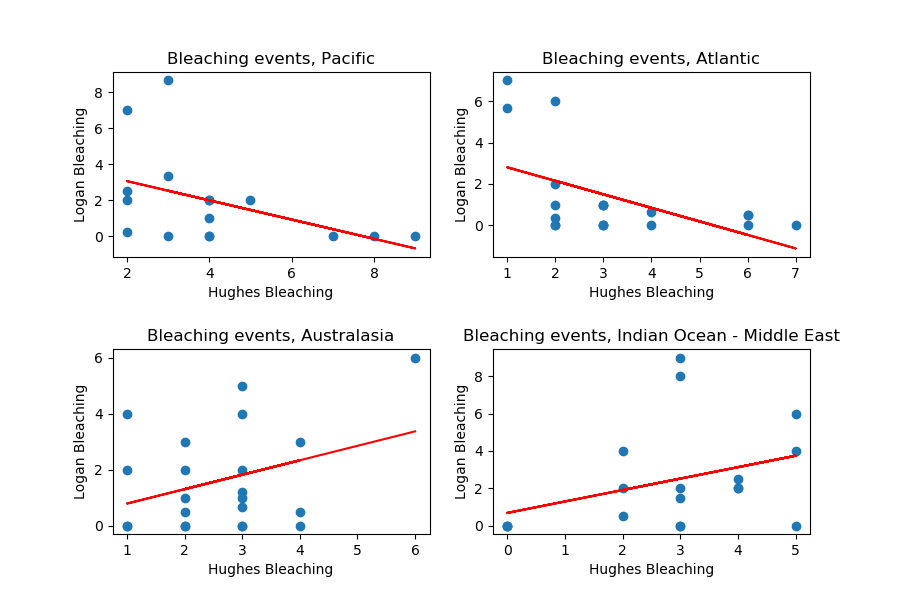

Pacific r-squared: 0.20106817711092898
Atlantic r-squared: 0.27113209700579427
Australasia r-squared: 0.12012090457134492
Indian Ocean - Middle East r-squared: 0.12581939870166992


In [56]:
# Now see if the correlation is better regionally.
plt.figure(figsize=[9, 6])
plt.subplot(2,2,1)
h_match_region = h_match[h_match['Region'] == 'Pac']
bleach_scatter(h_match_region, 'Pacific')
plt.subplot(2,2,2)
h_match_region = h_match[h_match['Region'] == 'WAtl']
bleach_scatter(h_match_region, 'Atlantic')
plt.subplot(2,2,3)
h_match_region = h_match[h_match['Region'] == 'AuA']
bleach_scatter(h_match_region, 'Australasia')
plt.subplot(2,2,4)
h_match_region = h_match[h_match['Region'] == 'IO-ME']
bleach_scatter(h_match_region, 'Indian Ocean - Middle East')
plt.subplots_adjust(hspace=0.5, wspace=0.2)


### Outlier notes
The two Pacific outlying locations are in the Galapagos and Kiribati, to use their Hughes names.  
The Galapagos has a land area of around 7000 $km^2$ and Hughes has a reef area of 126 $km^2$.
Kiribati has a land area of 800 $km^2$ (wikipedia) and Hughes has a reef area of 1718 $km^2$.
While Kiribati is closer to the Galapagos than most Pacific islands and they are both
equatorial, they are quite far apart (over 90 deg longitude) and there is little reason
to group them.

The three Atlantic outlying locations are Bonaire, Curacao, and Venezuela, to use their Hughes names.  
Curacao has a land area of 444 $km^2$ (Wikipedia) and Hughes has a reef area of 47 $km^2$.
Bonaire has a land area of 295 $km^2$ (wikipedia) and Hughes has a reef area of 22 $km^2$.
Venezuela is continental, and the Hughes are is 349 $km^2$, perhaps corresponding to the Gran Roque reef east of Bonaire.
It is interesting that these outliers are adjacent, and have low bleaching according to Hughes and higher bleaching in our model.
Repeating the plot with these three locations removed only decreases the $R^2$ value, and the slope is still negative.

## Another subset approach - by size
Plot this same comparison using only the smallest and only the largest reef areas, based on Hughes


<IPython.core.display.Javascript object>


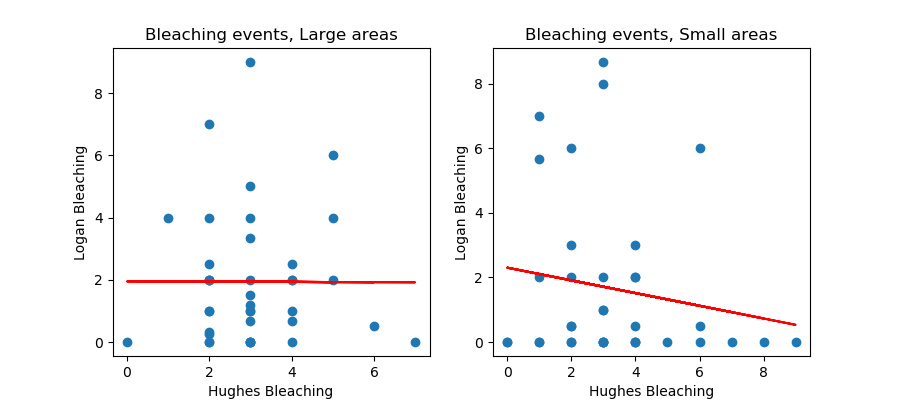

Large areas r-squared: 7.05454151843201e-06
Small areas r-squared: 0.026231591776090857


In [57]:
median_area = np.median(h_match['Size_km2'])
h_match_big = h_match[h_match['Size_km2'] >= median_area]
h_match_small = h_match[h_match['Size_km2'] < median_area]

plt.figure(figsize=[9, 4])
# Biggest half
plt.subplot(1,2,1)
bleach_scatter(h_match_big, 'Large areas')

# Smallest half
plt.subplot(1,2,2)
bleach_scatter(h_match_small, 'Small areas')

<a id="pca"></a>
## Principal Components Analysis
Given that the scatter plots don't show relationships at the global or regional level, perhaps PCA can reveal some grouping by temperature, temperature variability, or longitude which will turn up something interesting.

In [ ]:
# As a numerical value, the absolute value of latitude is more likely to be useful than the
# signed value.
cells['abs_lat'] = abs(cells['Lat'])

all_names = list(cells)
all_names

In [ ]:
import copy
# function moved so this project is self-contained:
import principal_component as pc

# Longitude does have a relationship with bleaching, but it's more categorical
# than scalar, so omit it.  Also omit signed Latitude.  Also remove Region, because it is
# categorical and we hope to find a better grouping.
print('PCA including only unsigned latitude:')
print('all names:', all_names)
# Without deepcopy, removing names from the list affects the original.
reduced_names = copy.deepcopy(all_names)
reduced_names.remove('Lat')
reduced_names.remove('Lon')
reduced_names.remove('Region')
reduced_names.remove('RegionFlag')
reduced_names.remove('Events')

[eigenval, eigenvec, pct_acct, loadings, sorted_names] = pc.pca(np.asmatrix(cells[reduced_names]),
     reduced_names, standardize=True, sort=True)
print('Names:    ', sorted_names)
print('Eigenvalues:\n', eigenval)
print('Eigenvectors:\n', eigenvec)
print('Variance accounted for by each component:\n', pct_acct)
#print('Component loadings:\n', loadings)

In [ ]:
# Now look at factor loadings for the reduced list
# A = V (sqrt(Lambda))
# V = eigenvectors = eigenvec
# Lambda = eigenvalue matrix = eigenval
A = np.matmul(eigenvec, np.diag(eigenval)**0.5)
# A now contains the loadings for PC1 in the first row, and so on.
A
plt.figure()
plt.plot(A[:, 0], A[:, 1], 'o')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('PC1 loading')
plt.ylabel('PC2 loading')
for i, txt in enumerate(sorted_names):
    plt.text(A[i,0]+0.05,A[i,1],txt)
sorted_names

### Elimination of PCA
Since there are so few variables, PCA was not likely to be useful here, but I have included it because it was interesting as a way of thinking through the possible contribution of each  variable.  The plot about does not seem to reveal anything useful.

<a id="variable_scatter"></a>
## Looking at scatter plots for Hughes/Logan correlation
Since Principal Components Analysis did not seem helpful here, I tried simply plotting each variable against the others.  Plots for all reefs are shown below, and versions for each region separately are in another notebook.  [Reef_Scatterplots](Reef_Scatterplots.ipynb)

In [ ]:
from coral_project_functions import scatter_all
plt.figure()
scatter_all(cells[['Events', 'abs_lat', 'SST', 'variance']])   

<a id="cumulative"></a>
## Cumulative Bleaching approach
Perhaps reefs will simply not correlate on an individual basis, but the cumulative bleaching in an area is of interest.  Go back to using the hughes and cells arrays without regard to individual matches.  The plot below is scale to show the same number of total events.

In [ ]:
# Make the same plots using a function
from coral_project_functions import bleach_annual_plot

# The annual bleaching count for the whole world, based on Logan et al. (2018)
plt.figure(figsize=[9, 6])
bleach_annual_plot(branching_bleach, massive_bleach, hughes, 'World')



#shiftYear = -1.5
#plt.plot(range(1980, 2017), hughes_norm, label='Hughes')
#plt.plot(shiftYear+np.array(range(1980, 2017)), cell_norm, label='Logan')
#plt.legend()

In [ ]:
# Now do the same thing for each region separately.
plt.figure(figsize=[9, 6])
plt.subplot(2,2,1)
c_idx = cells['Region'] == 'AuA'
h_idx = hughes['Region'] == 'AuA'
bleach_annual_plot(branching_bleach[c_idx], massive_bleach[c_idx], hughes[h_idx], 'Australasia', True)

plt.subplot(2,2,2)
c_idx = cells['Region'] == 'Pac'
h_idx = hughes['Region'] == 'Pac'
bleach_annual_plot(branching_bleach[c_idx], massive_bleach[c_idx], hughes[h_idx], 'Pacific', True)

plt.subplot(2,2,3)
c_idx = cells['Region'] == 'IO-ME'
h_idx = hughes['Region'] == 'IO-ME'
bleach_annual_plot(branching_bleach[c_idx], massive_bleach[c_idx], hughes[h_idx], 'Indian Ocean - Middle East', True)


plt.subplot(2,2,4)
c_idx = cells['Region'] == 'WAtl'
h_idx = hughes['Region'] == 'WAtl'
bleach_annual_plot(branching_bleach[c_idx], massive_bleach[c_idx], hughes[h_idx], 'Western Atlantic - Caribbean', True)

plt.subplots_adjust(hspace=0.8, wspace=0.3)


## Interpretation of cumulative bleaching
1. The curves have been scaled to reach the same endpoint.  Only the rate of increase over time is of interest.
2. The model SST data matches the typical frequency of events such as El Nino, but not the exact timing, so the exact dates of jumps is not comparable.
3. This really should be repeated with actual historical temperatures, but I only fully appreciated that on May 7.  It is unlikely that I can obtain and scale appropriate data before the due date.

<a id='refs'></a>
__References__

Hughes, T. P. et al. Spatial and temporal patterns of mass bleaching of corals in the Anthropocene. Science 359, 80–83 (2018).

Logan, C. A., Dunne, J. P., Ryan, J. S., Baskett, M. L. & Donner, S. D. Can symbiont diversity and evolution allow corals to keep pace with global warming and ocean acidification? prep (2018).

Logan, Cheryl A., John P. Dunne, C. Mark Eakin, and Simon D. Donner. 2014. “Incorporating Adaptive Responses into Future Projections of Coral Bleaching.” Global Change Biology 20 (1):125–39. https://doi.org/10.1111/gcb.12390.